# This notebook is to directly compare LCs (and transits) between NEMESIS, QLP, TGLC and SPOC photometry

In [109]:
# helper function to get HLSP from TESS
import astropy.units as u
import numpy as np
import os,sys
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
import lksearch as lk
from astropy.io import fits
import matplotlib.pyplot as plt

# Practice with TOI-270 (3 planet system)
ID= 259377017
Sector=3
radius=3*21*u.arcsec
cadence='30 minute'
downloadpath = os.getcwd()+'/HLSP/'

cadence_map = {
        'long': (30*u.minute , 'FFI'),
        '30 minute': (30*u.minute , 'FFI'),
        '10 minute': (10*u.minute , 'FFI'),
        'short': ( 2*u.minute , 'TPF'),
        '2 minute': ( 2*u.minute , 'TPF'),
        '20 second': (20*u.second, 'TPF'),
        'fast': (20*u.second, 'TPF') }

if cadence not in cadence_map:
    raise ValueError(f"Unrecognised cadence: {cadence!r}")
exp_u, ffi_or_tpf = cadence_map[cadence]
exptime     = int(exp_u.to(u.second).value)


# Helper function to download and standardize outputs from various TESS High Level Science Product pipelines

In [110]:
from __future__ import annotations

from typing import Any, Optional, Tuple, Union
import os
import re

import numpy as np
import pandas as pd
import astropy.units as u
from astropy.io import fits
import lksearch as lk



from __future__ import annotations

from typing import Dict, Iterable, Optional, Sequence, Tuple
import numpy as np
import pandas as pd


def standardize_lc(
    lc: pd.DataFrame,
    pipeline: str,
    *,
    strict: bool = False,
    case_insensitive: bool = True,
) -> pd.DataFrame:
    """Standardize a light-curve DataFrame from multiple TESS HLSP pipelines.

    Parameters
    ----------
    lc : pandas.DataFrame
        Input light-curve table from a given pipeline.
    pipeline : str
        Pipeline key used in the mapping (e.g., 'QLP', 'TESS-SPOC', 'TGLC', 'GSFC-ELEANOR-LITE').
    strict : bool, optional
        If True, raise KeyError when a required mapped input column is missing.
        If False, missing/None columns become NaN-filled outputs.
    case_insensitive : bool, optional
        If True, allows matching input columns ignoring case.

    Returns
    -------
    out : pandas.DataFrame
        DataFrame with standardized columns in a fixed order:
        ['Time', 'Raw Flux', 'Raw Flux Error', 'BKG Flux', 'BKG Flux Error',
         'Corrected Flux', 'Corrected Flux Error', 'Quality']

    Notes
    -----
    - Mapping is positional: the i-th old column maps to the i-th standardized column.
    - Any `None` in the mapping produces an all-NaN output column.

    Examples
    --------
    >>> import pandas as pd
    >>> df = pd.DataFrame({"time":[1.0, 2.0], "cal_psf_flux":[10.0, 11.0], "background":[0.1, 0.2], "TGLC_flags":[0, 1]})
    >>> out = standardize_lc(df, "TGLC")
    >>> list(out.columns)
    ['Time', 'Raw Flux', 'Raw Flux Error', 'BKG Flux', 'BKG Flux Error', 'Corrected Flux', 'Corrected Flux Error', 'Quality']
    >>> float(out["Raw Flux"].iloc[0])
    10.0
    >>> np.isnan(out["Raw Flux Error"].iloc[0])
    True
    """
    lc_map: Dict[str, Tuple[Optional[str], ...]] = {
        "QLP": (
            "TIME",
            "SAP_FLUX",
            "KSPSAP_FLUX_ERR",
            "SAP_BKG",
            "SAP_BKG_ERR",
            "KSPSAP_FLUX",
            "KSPSAP_FLUX_ERR",
            "QUALITY",
        ),
        "TESS-SPOC": (
            "TIME",
            "SAP_FLUX",
            "SAP_FLUX_ERR",
            "SAP_BKG",
            "SAP_BKG_ERR",
            "PDCSAP_FLUX",
            "PDCSAP_FLUX_ERR",
            "QUALITY",
        ),
        "TGLC": (
            "time",
            "aperture_flux",
            None,
            "background",
            None,
            "cal_aper_flux",
            None,
            "TGLC_flags",
        ),
        "GSFC-ELEANOR-LITE": (
            "TIME",
            "RAW_FLUX",
            "FLUX_ERR",
            "FLUX_BKG",
            None,
            "PCA_FLUX",
            "FLUX_ERR",
            "QUALITY",
        ),
    }

    standard_cols: Tuple[str, ...] = (
        "Time",
        "Raw Flux",
        "Raw Flux Error",
        "BKG Flux",
        "BKG Flux Error",
        "Corrected Flux",
        "Corrected Flux Error",
        "Quality",
    )

    if pipeline not in lc_map:
        raise KeyError(
            f"Unknown pipeline='{pipeline}'. Supported: {sorted(lc_map.keys())}"
        )

    old_cols = lc_map[pipeline]
    if len(old_cols) != len(standard_cols):
        raise ValueError(
            f"Mapping for pipeline='{pipeline}' has {len(old_cols)} columns, "
            f"expected {len(standard_cols)}."
        )

    # Build a resolver for case-insensitive matching, if requested
    if case_insensitive:
        col_lookup = {str(c).casefold(): c for c in lc.columns}
        def resolve(name: str) -> Optional[str]:
            return col_lookup.get(name.casefold())
    else:
        def resolve(name: str) -> Optional[str]:
            return name if name in lc.columns else None

    out = pd.DataFrame(index=lc.index)

    for old_name, new_name in zip(old_cols, standard_cols):
        if old_name is None:
            out[new_name] = np.nan
            continue

        actual = resolve(old_name)
        if actual is None:
            if strict:
                raise KeyError(
                    f"Missing column '{old_name}' for pipeline='{pipeline}'. "
                    f"Available columns: {list(lc.columns)}"
                )
            out[new_name] = np.nan
            continue

        out[new_name] = lc[actual].to_numpy(copy=False)

    return out


def get_tess_LC(
    TIC_ID: Union[int, str],
    radius: Union[float, u.Quantity],
    exptime: Union[str, int, Tuple[float, float]],
    Sector: Optional[Union[int, list[int]]],
    pipeline: str,
    downloadpath: str,
    *,
    verbose: bool = True,
) -> Tuple[Any, pd.DataFrame]:
    """Download one TESS HLSP light curve (FITS) via lksearch and return it as a DataFrame.

    Parameters
    ----------
    TIC_ID : int | str
        TIC identifier (e.g., 123456789).
    radius : float | astropy.units.Quantity
        Search radius. If float, lksearch interprets it as arcseconds. :contentReference[oaicite:4]{index=4}
        You may also pass an explicit Quantity (e.g., 30*u.arcsec).
    exptime : str | int | (float, float)
        Exposure time filter passed to lksearch (e.g. "shortest", 120, (100, 500)). :contentReference[oaicite:5]{index=5}
    Sector : int | list[int] | None
        TESS sector(s) to filter on.
    pipeline : str
        HLSP pipeline name to filter on (e.g., "QLP", "TASOC", "TESS-SPOC", etc.). :contentReference[oaicite:6]{index=6}
    downloadpath : str
        Directory where products will be downloaded.
    verbose : bool, optional (keyword-only)
        If True, prints a compact summary of matching pipelines and the selected product.

    Returns
    -------
    product : lksearch.TESSSearch (single-row)
        A TESSSearch object containing exactly one selected product row.
    df : pandas.DataFrame
        Light curve table from the first table-like FITS extension.

    Raises
    ------
    ValueError
        If no matching HLSP timeseries products are found for the requested pipeline.
    """
    os.makedirs(downloadpath, exist_ok=True)

    tic_str = str(TIC_ID).strip()
    # Normalize "123.0" -> "123" if user passed a float-like string
    try:
        tic_str = str(int(float(tic_str)))
    except Exception:
        pass

    # lksearch treats float search_radius as arcseconds by default. :contentReference[oaicite:7]{index=7}
    search_radius = float(radius) if isinstance(radius, (int, float, np.floating)) else radius

    # 1) Query
    search = lk.TESSSearch(
        target=f"TIC {tic_str}",
        search_radius=search_radius,
        exptime=exptime,
        sector=Sector,
        hlsp=True,
    )

    # 2) Restrict to time-series products, then filter to HLSP + pipeline
    try:
        ts = search.timeseries
    except AttributeError:
        # Very defensive fallback; docs/tutorials show .timeseries exists. :contentReference[oaicite:8]{index=8}
        ts = search

    # Filter to HLSP + pipeline (and keep exptime/sector constraints via ctor inputs)
    filtered = ts.filter_table(mission="HLSP", pipeline=pipeline)

    if filtered.table is None or len(filtered.table) == 0:
        # Build helpful debug context from whatever we *did* get back
        table = getattr(ts, "table", None)
        if isinstance(table, pd.DataFrame) and len(table) > 0:
            if "mission" in table.columns:
                hlsp_tbl = table[table["mission"].astype(str).eq("HLSP")]
            else:
                hlsp_tbl = table

            avail = (
                np.unique(hlsp_tbl["pipeline"].astype(str))
                if "pipeline" in hlsp_tbl.columns and len(hlsp_tbl) > 0
                else np.array([])
            )
            msg = (
                f"No HLSP timeseries products found for pipeline='{pipeline}' "
                f"(TIC={tic_str}, sector={Sector}, exptime={exptime}, radius={radius}). "
                f"Available HLSP pipelines in this search: {avail.tolist()}"
            )
        else:
            msg = (
                f"No products returned at all (TIC={tic_str}, sector={Sector}, "
                f"exptime={exptime}, radius={radius})."
            )
        raise ValueError(msg)

    tbl = filtered.table.copy()

    # 3) Pick best row:
    #    (a) prefer rows whose target_name contains the TIC id
    #    (b) then smallest distance (closest on-sky match)
    if "target_name" in tbl.columns:
        pat = re.compile(rf"(^|\D){re.escape(tic_str)}(\D|$)")
        mask = tbl["target_name"].astype(str).apply(lambda s: bool(pat.search(s)))
        if mask.any():
            tbl = tbl[mask]

    if "distance" in tbl.columns:
        tbl = tbl.sort_values("distance", ascending=True)

    best_tbl = tbl.iloc[[0]].reset_index(drop=True)

    # Create a single-row TESSSearch object so download() only pulls one file.
    product = lk.TESSSearch(table=best_tbl)

    if verbose:
        cols = [c for c in ["target_name", "pipeline", "mission", "sector", "exptime", "distance", "year", "description"] if c in best_tbl.columns]
        print("Selected product row:")
        print(best_tbl[cols] if cols else best_tbl.head(1))

    # 4) Download
    manifest = product.download(download_dir=downloadpath)

    # 5) Extract local path robustly
    if not isinstance(manifest, pd.DataFrame) or len(manifest) == 0:
        raise ValueError("Download returned an empty manifest; nothing was downloaded.")

    # lksearch manifest uses 'Local Path' in tutorials. :contentReference[oaicite:9]{index=9}
    path_col = None
    for c in manifest.columns:
        canon = c.lower().replace(" ", "").replace("_", "")
        if canon in {"localpath"}:
            path_col = c
            break
    if path_col is None:
        raise ValueError(f"Could not find a Local Path column in download manifest. Columns: {list(manifest.columns)}")

    local_path = str(manifest[path_col].iloc[0])

    # 6) Read FITS, grab first table-like extension, convert to DataFrame
    with fits.open(local_path, memmap=False) as hdul:
        table_hdu = None
        for hdu in hdul[1:]:
            data = getattr(hdu, "data", None)
            if data is None:
                continue
            # Prefer a named LIGHTCURVE extension if present; else first BinTable-like HDU
            extname = str(getattr(hdu, "name", "")).upper()
            if hasattr(data, "names") and extname in {"LIGHTCURVE", "LIGHTCURVES", "LC", "TIME_SERIES", "TIMESERIES"}:
                table_hdu = hdu
                break
            if table_hdu is None and hasattr(data, "names"):
                table_hdu = hdu

        if table_hdu is None:
            raise ValueError(f"No table-like FITS extension found in file: {local_path}")

        rec = np.array(table_hdu.data)

        # Ensure native endianness (handles some FITS tables cleanly)
        if hasattr(rec.dtype, "isnative") and not rec.dtype.isnative:
            try:
                rec = rec.byteswap().newbyteorder()
            except AttributeError:
                # numpy>=2 compatibility path for newbyteorder changes
                rec = rec.byteswap().view(rec.dtype.newbyteorder("="))

        df = pd.DataFrame.from_records(rec)
        
        
        
        newdf = standardize_lc(df,pipeline)

    return product, df, newdf



r, lc, newlc = get_tess_LC(
    TIC_ID=ID,
    radius=21,          # arcsec
    exptime=1800,
    Sector=3,
    pipeline="TESS-SPOC",   # example; replace with what you use
    downloadpath=downloadpath
)


Search radius 21.0 units not specified, assuming arcsec


Selected product row:
  target_name   pipeline mission  sector  exptime  distance  year description
0   259377017  TESS-SPOC    HLSP       3   1800.0       0.0  2018        FITS


In [112]:
print(r,'\n')         # should say "TESSSearch object containing 1 data products"
print(lc.columns[:10],'\n')
print(lc.head())


TESSSearch object containing 1 data products 
  target_name   pipeline mission  sector  exptime  distance  year description
0   259377017  TESS-SPOC    HLSP       3   1800.0       0.0  2018        FITS 

Index(['TIME', 'TIMECORR', 'CADENCENO', 'SAP_FLUX', 'SAP_FLUX_ERR', 'SAP_BKG',
       'SAP_BKG_ERR', 'PDCSAP_FLUX', 'PDCSAP_FLUX_ERR', 'QUALITY'],
      dtype='object') 

          TIME  TIMECORR  CADENCENO     SAP_FLUX  SAP_FLUX_ERR      SAP_BKG  \
0  1382.053907  0.001262       7420  8348.148438      2.907079  1366.653320   
1  1382.074741  0.001262       7421  8342.750000      2.899137  1329.218140   
2  1382.095574  0.001263       7422  8351.673828      2.895285  1302.328369   
3  1382.116408  0.001263       7423  8350.665039      2.890686  1280.227417   
4  1382.137242  0.001264       7424  8348.654297      2.885473  1256.456665   

   SAP_BKG_ERR  PDCSAP_FLUX  PDCSAP_FLUX_ERR  QUALITY  PSF_CENTR1  \
0     0.871324          NaN              NaN      136         NaN   
1     0.8631

In [113]:
newlc.head(1)

,Time,Raw Flux,Raw Flux Error,BKG Flux,BKG Flux Error,Corrected Flux,Corrected Flux Error,Quality
0,1382.053907,8348.148438,2.907079,1366.65332,0.871324,NaN,NaN,136


In [114]:
pipelines=['TGLC','QLP','TESS-SPOC','GSFC-ELEANOR-LITE']


for P in pipelines:
    globals()[f"{P}_r"], globals()[f"{P}_LC"], globals()[f"{P}_newLC"] = get_tess_LC(
    TIC_ID=ID,
    radius=3*21*u.arcsec,          # arcsec
    exptime=1800,
    Sector=3,
    pipeline=P,   # example; replace with what you use
    downloadpath=downloadpath)
    
    globals()[f"{P}_newLC_masked"]=globals()[f"{P}_newLC"].loc[globals()[f"{P}_newLC"]['Quality']==0]
    

Selected product row:
  target_name pipeline mission  sector  exptime  distance  year description
0   259377017     TGLC    HLSP       3   1800.0   0.60232  2018        FITS
Selected product row:
  target_name pipeline mission  sector  exptime  distance  year description
0   259377017      QLP    HLSP       3   1800.0       0.0  2018        FITS
Selected product row:
  target_name   pipeline mission  sector  exptime  distance  year description
0   259377017  TESS-SPOC    HLSP       3   1800.0       0.0  2018        FITS
Selected product row:
  target_name           pipeline mission  sector  exptime  distance  year  \
0   259377017  GSFC-ELEANOR-LITE    HLSP       3   1800.0       0.0  2018   

  description  
0        FITS  


In [115]:
#generate N distinct colors for plotting

import numpy as np
import colorsys

def _get_colors(num_colors):
    colors=[]
    for i in np.arange(0., 360., 360. / num_colors):
        hue = i/360.
        lightness = (50 + np.random.rand() * 10)/100.
        saturation = (90 + np.random.rand() * 10)/100.
        colors.append(colorsys.hls_to_rgb(hue, lightness, saturation))
    return colors
pipeline_colors = _get_colors(len(pipelines))
pipeline_colors

[(0.9706566884215186, 0.22922192971676325, 0.22922192971676325),
 (0.5885005643875807, 0.995906398305886, 0.18109473046927493),
 (0.1353293742248285, 0.9783739594197687, 0.9783739594197689),
 (0.5385354467062659, 0.07990877822528264, 0.99716211518725)]

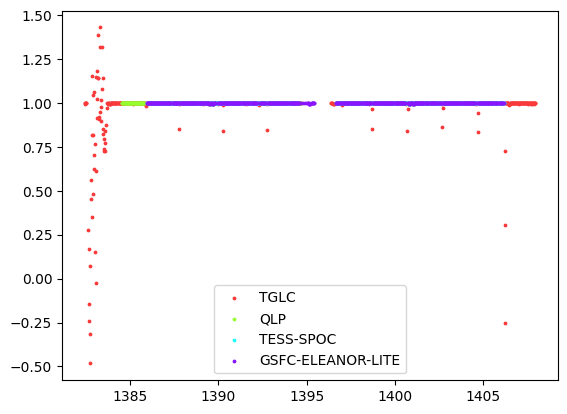

In [116]:
for pp in range(len(pipelines)):
    P = pipelines[pp]
    C = pipeline_colors[pp]
    
    plt.scatter(globals()[f"{P}_newLC_masked"]['Time'],
                globals()[f"{P}_newLC_masked"]['Corrected Flux']/np.nanmedian(globals()[f"{P}_newLC_masked"]['Corrected Flux']),
                s=3,label=P,color=C)
plt.legend(loc='best')
plt.show()

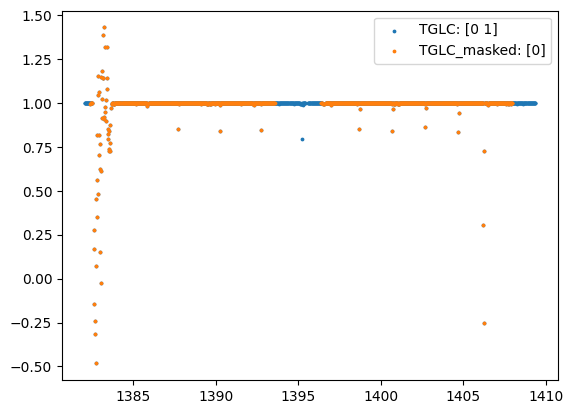

In [117]:
# For TGLC, is quality flag = 0 the "good quality" data? (Double check!)

P='TGLC'
np.unique(globals()[f"{P}_newLC"]['Quality'])


plt.scatter(globals()[f"{P}_newLC"]['Time'],
            globals()[f"{P}_newLC"]['Corrected Flux']/np.nanmedian(globals()[f"{P}_newLC"]['Corrected Flux']),
                s=3,label=P+f': {np.unique(globals()[f"{P}_newLC"]['Quality'])}')
plt.scatter(globals()[f"{P}_newLC_masked"]['Time'],
            globals()[f"{P}_newLC_masked"]['Corrected Flux']/np.nanmedian(globals()[f"{P}_newLC_masked"]['Corrected Flux']),
                s=3,label=P+f'_masked: {np.unique(globals()[f"{P}_newLC_masked"]['Quality'])}')
plt.legend(loc='best')
plt.show()





In [118]:
nearby_TOI_MD_df=pd.read_csv('/Users/daxfeliz/Desktop/TESS/0_target_selection/casjobs_queries/nearby_TOI_MDs.csv')
nearby_TOI_MD_df.head(5)


,Unnamed: 0,Parameter Source Pipeline,Detection Pipeline(s),TIC ID,Full TOI ID,TOI Disposition,TIC Right Ascension,TIC Declination,TIC Right Ascension 2015.5,TIC Declination 2015.5,TMag Value,TMag Uncertainty,Orbital Epoch Value,Epoch Uncertainty,Orbital Period (days) Value,Orbital Period Uncertainty,Transit Duration (hours) Value,Transit Duration (hours) Uncertainty,Transit Depth Value,Transit Depth Uncertainty,Sectors,Public Comment,Surface Gravity Value,Surface Gravity Uncertainty,Planet Number,Star Radius Value,Star Radius Uncertainty,Planet Radius Value,Planet Radius Uncertainty,Planet Equilibrium Temperature (K) Value,Effective Temperature Value,Effective Temperature Uncertainty,Effective Stellar Flux Value,Signal-to-noise,Centroid Offset,Master,SG1a,SG1b,SG2,SG3,SG4,SG5,Alerted,Updated,ID,ra,dec,pmRA,pmDEC,Tmag,objType,typeSrc,version,HIP,TYC,UCAC,TWOMASS,SDSS,ALLWISE,GAIA,APASS,KIC,POSflag,e_pmRA,e_pmDEC,PMflag,plx,e_plx,PARflag,gallong,gallat,eclong,eclat,Bmag,e_Bmag,Vmag,e_Vmag,umag,e_umag,gmag,e_gmag,rmag,e_rmag,imag,e_imag,zmag,e_zmag,Jmag,e_Jmag,Hmag,e_Hmag,Kmag,e_Kmag,TWOMflag,prox,w1mag,e_w1mag,w2mag,e_w2mag,w3mag,e_w3mag,w4mag,e_w4mag,GAIAmag,e_GAIAmag,e_Tmag,TESSflag,SPFlag,Teff,e_Teff,logg,e_logg,MH,e_MH,rad,e_rad,mass,e_mass,rho,e_rho,lumclass,lum,e_lum,d,e_d,ebv,e_ebv,numcont,contratio,disposition,duplicate_id,priority,eneg_EBV,epos_EBV,EBVflag,eneg_Mass,epos_Mass,eneg_Rad,epos_Rad,eneg_rho,epos_rho,eneg_logg,epos_logg,eneg_lum,epos_lum,eneg_dist,epos_dist,distflag,eneg_Teff,epos_Teff,TeffFlag,gaiabp,e_gaiabp,gaiarp,e_gaiarp,gaiaqflag,starchareFlag,VmagFlag,BmagFlag,splists,e_RA,e_Dec,RA_orig,Dec_orig,e_RA_orig,e_Dec_orig,raddflag,wdflag,dstArcSec,qld_a,qld_b,i,M_planet [ME],K_RV [m/s],TSM,ESM,Stellar Insolation [ergs/cm^2/s],Stellar Insolation [Earth Units],Sectors_Observed,Cameras,CCDs,EdgeWarn
0,0,spoc-s01-s36-b0A-CPKP,SPOC,410153553,136.01,PC,340.492100,-69.169000,340.496204,-69.172108,11.877,0.064,1325.724661,0.000156,0.462931,3.872269e-06,0.631015,0.022202,4677.673602,171.681260,"1,27,28,67,68,94,95,101,102,103,104",LHS 3844 b,5.09707,0.426694,1,0.188624,0.005710,1.517197,0.061800,723.372047,3043.0,63.0,64.709477,38.885654,False,5,5,5,5,5,5,5,2018-09-05 18:51:57+00:00,2020-10-27 13:01:47.547000+00:00,410153553,340.492156,-69.168978,334.3570,-726.9740,11.92380,STAR,tmgaia2,20190415,NaN,NaN,105-116381,22415815-6910089,NaN,NaN,6385548541499112448,33464847.0,NaN,tmgaia2,0.082820,0.086335,gaia2,67.15480,0.050599,gaia2,318.253844,-43.907555,304.887051,-54.122569,16.942,0.041,15.240,0.032,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.046,0.023,9.477,0.023,9.145,0.023,AAA-222-111-000-0-0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.3925,0.000738,0.007698,cdwrf,cdwrf,3004.0,157.0,5.08528,0.029186,NaN,NaN,0.188624,0.005710,0.157909,0.020067,23.52970,0.863072,DWARF,0.002610,0.000708,14.8846,0.0113,0.000000,0.000000,81.0,0.010833,NaN,NaN,0.009687,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0113,0.0113,bj2018,NaN,NaN,cdwrf,15.4512,0.007263,12.05170,0.002827,1,NaN,cdwrf,apassdr9,cooldwarfs_v8,1.559812,1.338867,340.496204,-69.172108,0.041207,0.042399,1,0,0.0,0.1933,0.5347,1.570796,2.913518,8.243782,328.631928,NaN,8.866874e+07,64.915025,11.0,"3,3,3,2,2,2,2,4,4,3,3","2,1,2,2,1,2,1,3,2,3,2","0,0,0,0,0,0,0,0,0,0,0"
1,1,spoc-s01-s69-b0A-CP,SPOC/QLP,234994474,134.01,CP,350.031300,-60.065200,350.028592,-60.065729,9.169,0.019,1326.034032,0.000566,1.401518,4.810232e-06,1.158306,0.325507,593.754092,42.808456,"1,28,68,95,102,104,105",L 168-9 b,4.67812,0.063226,1,0.597007,0.018150,1.461685,1.838503,891.638989,3794.0,69.0,149.374754,20.450527,False,5,5,5,5,5,5,5,2018-09-05 18:51:57+00:00,2024-09-30 23:32:46.016000+00:00,234994474,350.031352,-60.065179,-319.9610,-127.7810,9.22978,STAR,tmgaia2,20190415,115211.0,9126-00748-1,150-224713,23200751-6003545,NaN,NaN,6491962296196145664,31785853.0,NaN,tmgaia2,0.102122,0.115073,gaia2,39.73310,0.037526,gaia2,321.954596,-53.560374,319.217901,-49.527946,12.460,0.025,11.005,0.018,Na

# grab a TOI by name and extract LCs

In [94]:
target=nearby_TOI_MD_df.loc[nearby_TOI_MD_df['Planet Radius Value']==np.nanmax(nearby_TOI_MD_df['Planet Radius Value'])].reset_index(drop=True)
target_P= target['Orbital Period (days) Value'].item()
target_T0= target['Orbital Epoch Value'].item()
target_Dep = target['Transit Depth Value'].item()/1e6
target_Dur = target['Transit Duration (hours) Value'].item()

target_Sector = np.min(list(map(int, target['Sectors'].to_list()[0].split(',')))) #choosing 1st sector
ID=target['TIC ID'].item()

print(target_P,target_T0,target_Dur,target_Dep,ID,target_Sector)



pipelines=['TGLC','QLP','TESS-SPOC','GSFC-ELEANOR-LITE']


for P in pipelines:
    print(f'Trying to get {P} LC for TIC {ID} in Sector {target_Sector}')
    globals()[f"{P}_r"], globals()[f"{P}_LC"], globals()[f"{P}_newLC"] = get_tess_LC(
    TIC_ID=ID,
    radius=21,          # arcsec
    exptime=1800,
    Sector=target_Sector,
    pipeline=P,   # example; replace with what you use
    downloadpath=downloadpath)
    
    globals()[f"{P}_newLC_masked"]=globals()[f"{P}_newLC"].loc[globals()[f"{P}_newLC"]['Quality']==0]
    

Search radius 21.0 units not specified, assuming arcsec


0.5682596 2226.7836315 0.755 0.04254 52280468 6
Trying to get TGLC LC for TIC 52280468 in Sector 6
Selected product row:
  target_name pipeline mission  sector  exptime  distance  year description
0    52280468     TGLC    HLSP       6   1800.0       0.0  2018        FITS
Trying to get QLP LC for TIC 52280468 in Sector 6


Search radius 21.0 units not specified, assuming arcsec


Selected product row:
  target_name pipeline mission  sector  exptime  distance  year description
0    52280468      QLP    HLSP       6   1800.0       0.0  2018        FITS
Trying to get TESS-SPOC LC for TIC 52280468 in Sector 6


Search radius 21.0 units not specified, assuming arcsec


Selected product row:
  target_name   pipeline mission  sector  exptime  distance  year description
0    52280468  TESS-SPOC    HLSP       6   1800.0       0.0  2018        FITS
Trying to get GSFC-ELEANOR-LITE LC for TIC 52280468 in Sector 6


Search radius 21.0 units not specified, assuming arcsec


Selected product row:
  target_name           pipeline mission  sector  exptime  distance  year  \
0    52280468  GSFC-ELEANOR-LITE    HLSP       6   1800.0       0.0  2018   

  description  
0        FITS  


In [69]:
target

,Unnamed: 0,Parameter Source Pipeline,Detection Pipeline(s),TIC ID,Full TOI ID,TOI Disposition,TIC Right Ascension,TIC Declination,TIC Right Ascension 2015.5,TIC Declination 2015.5,TMag Value,TMag Uncertainty,Orbital Epoch Value,Epoch Uncertainty,Orbital Period (days) Value,Orbital Period Uncertainty,Transit Duration (hours) Value,Transit Duration (hours) Uncertainty,Transit Depth Value,Transit Depth Uncertainty,Sectors,Public Comment,Surface Gravity Value,Surface Gravity Uncertainty,Planet Number,Star Radius Value,Star Radius Uncertainty,Planet Radius Value,Planet Radius Uncertainty,Planet Equilibrium Temperature (K) Value,Effective Temperature Value,Effective Temperature Uncertainty,Effective Stellar Flux Value,Signal-to-noise,Centroid Offset,Master,SG1a,SG1b,SG2,SG3,SG4,SG5,Alerted,Updated,ID,ra,dec,pmRA,pmDEC,Tmag,objType,typeSrc,version,HIP,TYC,UCAC,TWOMASS,SDSS,ALLWISE,GAIA,APASS,KIC,POSflag,e_pmRA,e_pmDEC,PMflag,plx,e_plx,PARflag,gallong,gallat,eclong,eclat,Bmag,e_Bmag,Vmag,e_Vmag,umag,e_umag,gmag,e_gmag,rmag,e_rmag,imag,e_imag,zmag,e_zmag,Jmag,e_Jmag,Hmag,e_Hmag,Kmag,e_Kmag,TWOMflag,prox,w1mag,e_w1mag,w2mag,e_w2mag,w3mag,e_w3mag,w4mag,e_w4mag,GAIAmag,e_GAIAmag,e_Tmag,TESSflag,SPFlag,Teff,e_Teff,logg,e_logg,MH,e_MH,rad,e_rad,mass,e_mass,rho,e_rho,lumclass,lum,e_lum,d,e_d,ebv,e_ebv,numcont,contratio,disposition,duplicate_id,priority,eneg_EBV,epos_EBV,EBVflag,eneg_Mass,epos_Mass,eneg_Rad,epos_Rad,eneg_rho,epos_rho,eneg_logg,epos_logg,eneg_lum,epos_lum,eneg_dist,epos_dist,distflag,eneg_Teff,epos_Teff,TeffFlag,gaiabp,e_gaiabp,gaiarp,e_gaiarp,gaiaqflag,starchareFlag,VmagFlag,BmagFlag,splists,e_RA,e_Dec,RA_orig,Dec_orig,e_RA_orig,e_Dec_orig,raddflag,wdflag,dstArcSec,qld_a,qld_b,i,M_planet [ME],K_RV [m/s],TSM,ESM,Stellar Insolation [ergs/cm^2/s],Stellar Insolation [Earth Units],Sectors_Observed,Cameras,CCDs,EdgeWarn
0,37,qlp-s33-tois,SPOC/QLP,52280468,472.01,PC,99.866803,-33.540286,99.86703,-33.540223,12.29,0.018,2226.783631,0.001587,0.56826,0.000001,0.755,0.0,42540.0,0.841172,"6,7,33,87",no GAIA radius with Teff 3869K; large planet around an M star if real,4.438,0.0,1,0.5,0.02,24.8489,0.784699,954.0,3294.0,0.0,138.045,136.0,False,3,4,3,3,4,4,4,2019-02-22 14:51:22+00:00,2022-07-11 15:22:52.380000+00:00,52280468,99.866797,-33.540303,45.0688,18.4182,12.3123,STAR,tmgaia2,20190415,NaN,NaN,283-012187,06392802-3332250,NaN,J063928.06-333224.9,5583372517465364352,15238628.0,NaN,tmgaia2,3.7386,3.7386,hsoy,NaN,NaN,NaN,242.482472,-16.898076,104.984157,-56.467485,16.356,0.028,15.002,0.172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.766,0.026,10.177,0.022,9.918,0.021,AAA-222-111-000-0-0,NaN,9.781,0.023,9.618,0.021,9.458,0.035,8.436,NaN,13.5596,0.000548,0.007333,cdwrf,cdwrf,3364.0,157.0,4.73521,0.009199,NaN,NaN,0.502513,0.015836,0.500534,0.020942,3.9445,0.208119,DWARF,0.029135,0.007316,NaN,NaN,NaN,NaN,190.0,0.021652,NaN,NaN,0.001818,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cdwrf,15.01,0.003275,12.3799,0.001348,0,NaN,ucac4,apassdr9,cooldwarfs_v8,60.525435,57.948566,99.86703,-33.540223,0.15753,0.175565,1,0,0.0,0.1819,0.4364,1.570796,65877.461212,80677.213069,8.301612,NaN,3.489554e+08,255.47277,4.0,"3,3,3,3","1,2,1,1","0,0,0,0"


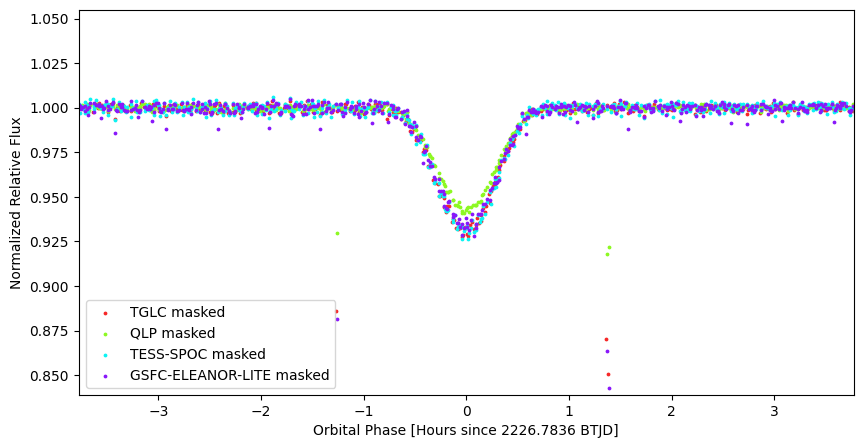

In [108]:
def phasefold(T0,time,period,flux):
    """
    This function will phase-fold the input light curve (time, flux)
    using a Mid-transit time and orbital period. The resulting phase
    is centered on the input Mid-transit time so that the transit
    occurs at phase 0.
    
    Input Parameters
    ----------
    time: array
        An array of timestamps from TESS observations.        
    TO : float
        The Mid-transit time of a periodic event.
    period : float
        An orbital period of a periodic event.
    flux : array
        An array of flux values from TESS observations.
    Returns
    -------
        * phase : array
            An array of Orbital phase of the phase-folded light curve.
        * flux : array
            An array of flux values from TESS observations of the 
            phase-folded light curve.
    """          
    phase=(time- T0 + 0.5*period) % period - 0.5*period
    ind=np.argsort(phase, axis=0)
    return phase[ind],flux[ind]


def plot_phasefolded(ax, target, lc, color, label):
    target_P= target['Orbital Period (days) Value'].item()
    target_T0= target['Orbital Epoch Value'].item()
    target_Dep = target['Transit Depth Value'].item()/1e6
    target_Dur = target['Transit Duration (hours) Value'].item()
       
    pf,ff = phasefold(T0=target_T0, time=lc['Time'].to_numpy(), 
                      period=target_P, flux=lc['Corrected Flux'].to_numpy()/np.nanmedian(lc['Corrected Flux'].to_numpy()))
    
    ax.scatter(24*pf,ff, s=3, color=color,label=label)
    ax.set_xlim(-5*target_Dur,5*target_Dur)
    
    ymin = np.nanmin(ff[np.abs(24*pf<5*target_Dur)]) - 3*np.nanstd(ff[np.abs(24*pf<5*target_Dur)])
    ymax = np.nanmax(ff[np.abs(24*pf<5*target_Dur)]) + 3*np.nanstd(ff[np.abs(24*pf<5*target_Dur)])
    return ymin,ymax
    
    
    
fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot(111)

all_ymins=[]
all_ymaxs=[]
for pp in range(len(pipelines)):
    P = pipelines[pp]
    C = pipeline_colors[pp]

    ymin,ymax = plot_phasefolded(ax=ax, target=target, lc=globals()[f"{P}_newLC"], 
                     color=C, label=f'{P} masked')
    all_ymins.append(ymin)
    all_ymaxs.append(ymax)    
    
    
    
ax.set_ylim(np.nanmedian(all_ymins),np.nanmedian(all_ymaxs))
ax.set_xlabel(f'Orbital Phase [Hours since {np.round(target['Orbital Epoch Value'].item(),4)} BTJD]')
ax.set_ylabel('Normalized Relative Flux')
ax.legend(loc='best',fontsize=10)
plt.show()

# Note that for the largest planet in nearby M-dwarfs, the depths are different (likely due to data processing differences in pipelines)